In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from scipy.io import loadmat
from spectral import *
from functions import *
import rasterio
import rasterio.plot
import warnings
import time

In [4]:
file_names = ['Airport','San_Diego']
data_dict = {}
map_dict = {}
for file_name in file_names:
    HSI = loadmat("./dataset/{}.mat".format(file_name))
    data_dict[file_name] = HSI['data']
    map_dict[file_name] = HSI['map']

In [5]:
seed = 2024
np.random.seed(seed)
rxval_dict = {}
lev_dict = {}
lev_fast_dict = {}
lev_min_dict = {}
lev_fast_min_dict = {}

rxval_time_dict = {}
lev_time_dict = {}
lev_fast_time_dict = {}
lev_fast_time_trick_dict = {}
order = [1,1]
for file_name in file_names:
    HSI = data_dict[file_name]
    img = np.mean(HSI,axis=2)
    start = time.time()
    rxval = rx(HSI)
    end = time.time()
    rxval_time_dict[file_name] = end - start

    start = time.time()
    lev = two_dim_AR_lev(img, order)
    end = time.time()
    lev_time_dict[file_name] = end - start

    start_fast = time.time()
    lev_fast = fast_2d_AR_leverage_score(img, order, subsample_size = 100)
    end_fast = time.time()
    lev_fast_time_dict[file_name] = end_fast - start_fast
    
    lev_min = lev_adjust(lev, order, method = 'min')
    lev_fast_min = lev_adjust(lev_fast, order, method = 'min')


    rxval_dict[file_name] = rxval / np.max(rxval)
    lev_dict[file_name] = lev
    lev_min_dict[file_name] = lev_min
    lev_fast_dict[file_name] = lev_fast
    lev_fast_min_dict[file_name] = lev_fast_min

In [7]:
approach_list = ['LARTVAD']
for approach in approach_list:
    i = 0
    exec(approach + '_dict={}')
    exec(approach + '_time_dict={}')
    exec(approach + '_AS=loadmat("./LARTVAD/'+ approach +'_AS.mat")["'+ approach +'_AS"]["as"][0]')
    exec(approach + '_time=loadmat("./LARTVAD/'+ approach +'_AS.mat")["'+ approach +'_AS"]["time"][0]')
    for file_name in file_names:
        exec(approach + '_dict["' + file_name + '"] = '+ approach + '_AS[{}]'.format(i))
        exec(approach + '_time_dict["' + file_name + '"] = float('+ approach + '_time[{}])'.format(i))
        i = i + 1

<string>:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


In [9]:
lev_dict = lev_min_dict
lev_fast_dict = lev_fast_min_dict

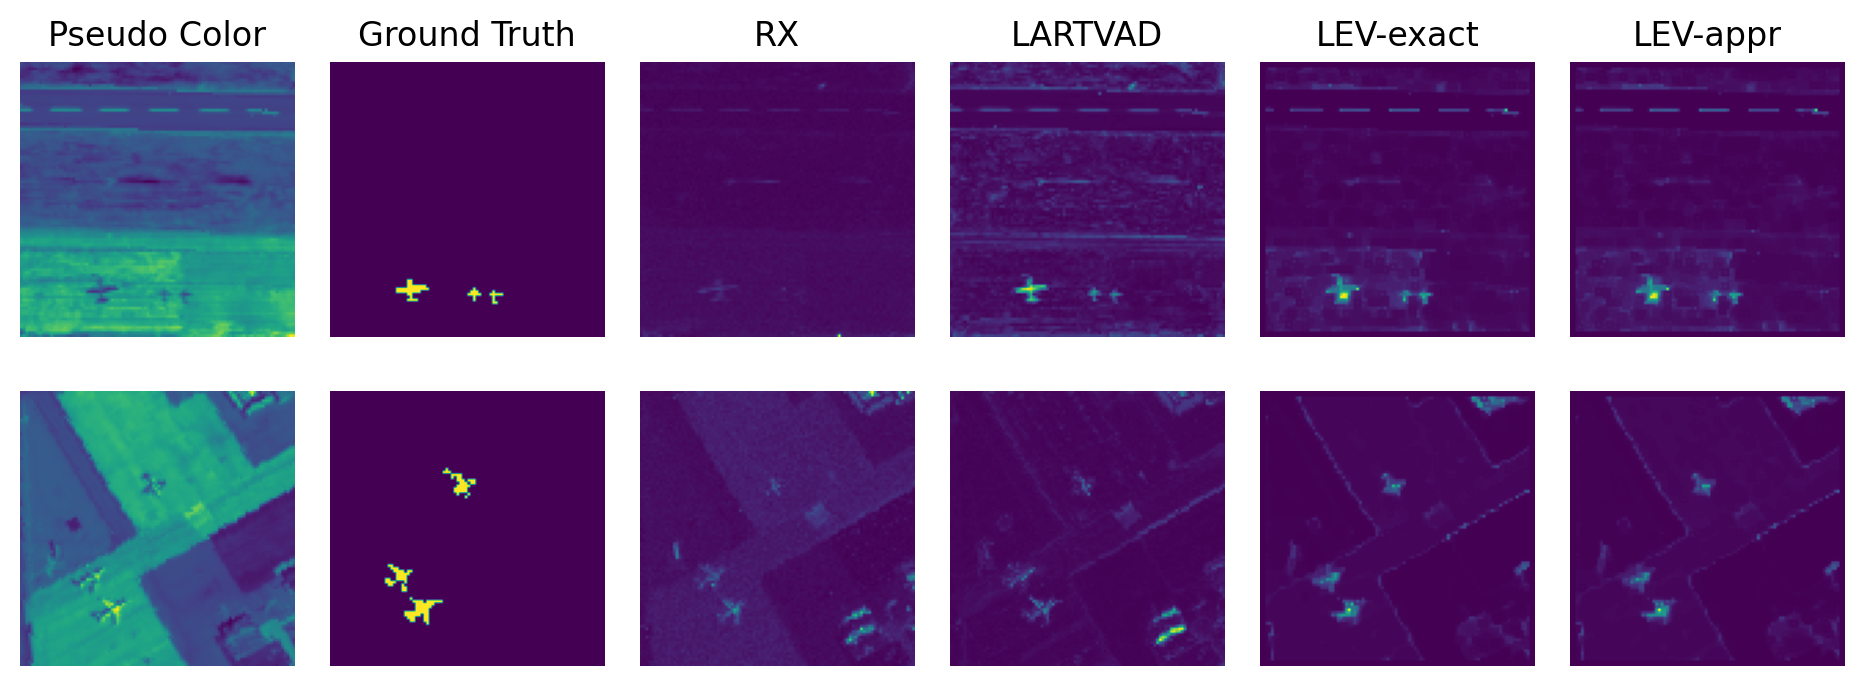

In [10]:
L = len(file_names)
approach_list = ['rxval', 'LARTVAD', 'lev', 'lev_fast']
app_num = len(approach_list) + 2
fig, ax = plt.subplots(nrows=L, ncols=app_num, figsize=(12, 4), dpi=200, sharex=True, sharey=True)
i = 0
for file_name in file_names:
    j = 1
    plt.subplot(L,app_num,i*app_num + j)
    if(i==0):
        plt.title('Pseudo Color')
    plt.imshow(np.mean(data_dict[file_name],axis=2))
    plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    j = j + 1

    plt.subplot(L,app_num,i*app_num + 2)
    if(i==0):
        plt.title('Ground Truth')
    plt.imshow(map_dict[file_name])
    plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    j = j + 1

    for approach in approach_list:
        plt.subplot(L,app_num,i*app_num + j)
        if(i==0):
            if(approach == 'rxval'):
                plt.title('RX')
            if(approach == 'lev'):
                plt.title('LEV-exact')
            if(approach == 'lev_fast'):
                plt.title('LEV-appr')
            if(approach == 'LARTVAD'):
                plt.title('LARTVAD')
        exec('plt.imshow(' + approach + '_dict["' + file_name + '"])')
        plt.axis('off')
        plt.xticks([])
        plt.yticks([])
        j = j + 1
    i = i + 1
plt.subplots_adjust(wspace=0)
plt.show()

In [11]:
map_adjust_dict = {}
for file_name in file_names:
    GT = map_dict[file_name]
    [m,n] = GT.shape
    GT_adjust = GT
    GT_adjust[0,:] = np.zeros(n)
    GT_adjust[1,:] = np.zeros(n)
    GT_adjust[m-1,:] = np.zeros(n)
    GT_adjust[m-2,:] = np.zeros(n)
    GT_adjust[:,0] = np.zeros(m)
    GT_adjust[:,1] = np.zeros(m)
    GT_adjust[:,n-1] = np.zeros(m)
    GT_adjust[:,n-2] = np.zeros(m)
    map_adjust_dict[file_name] = GT_adjust

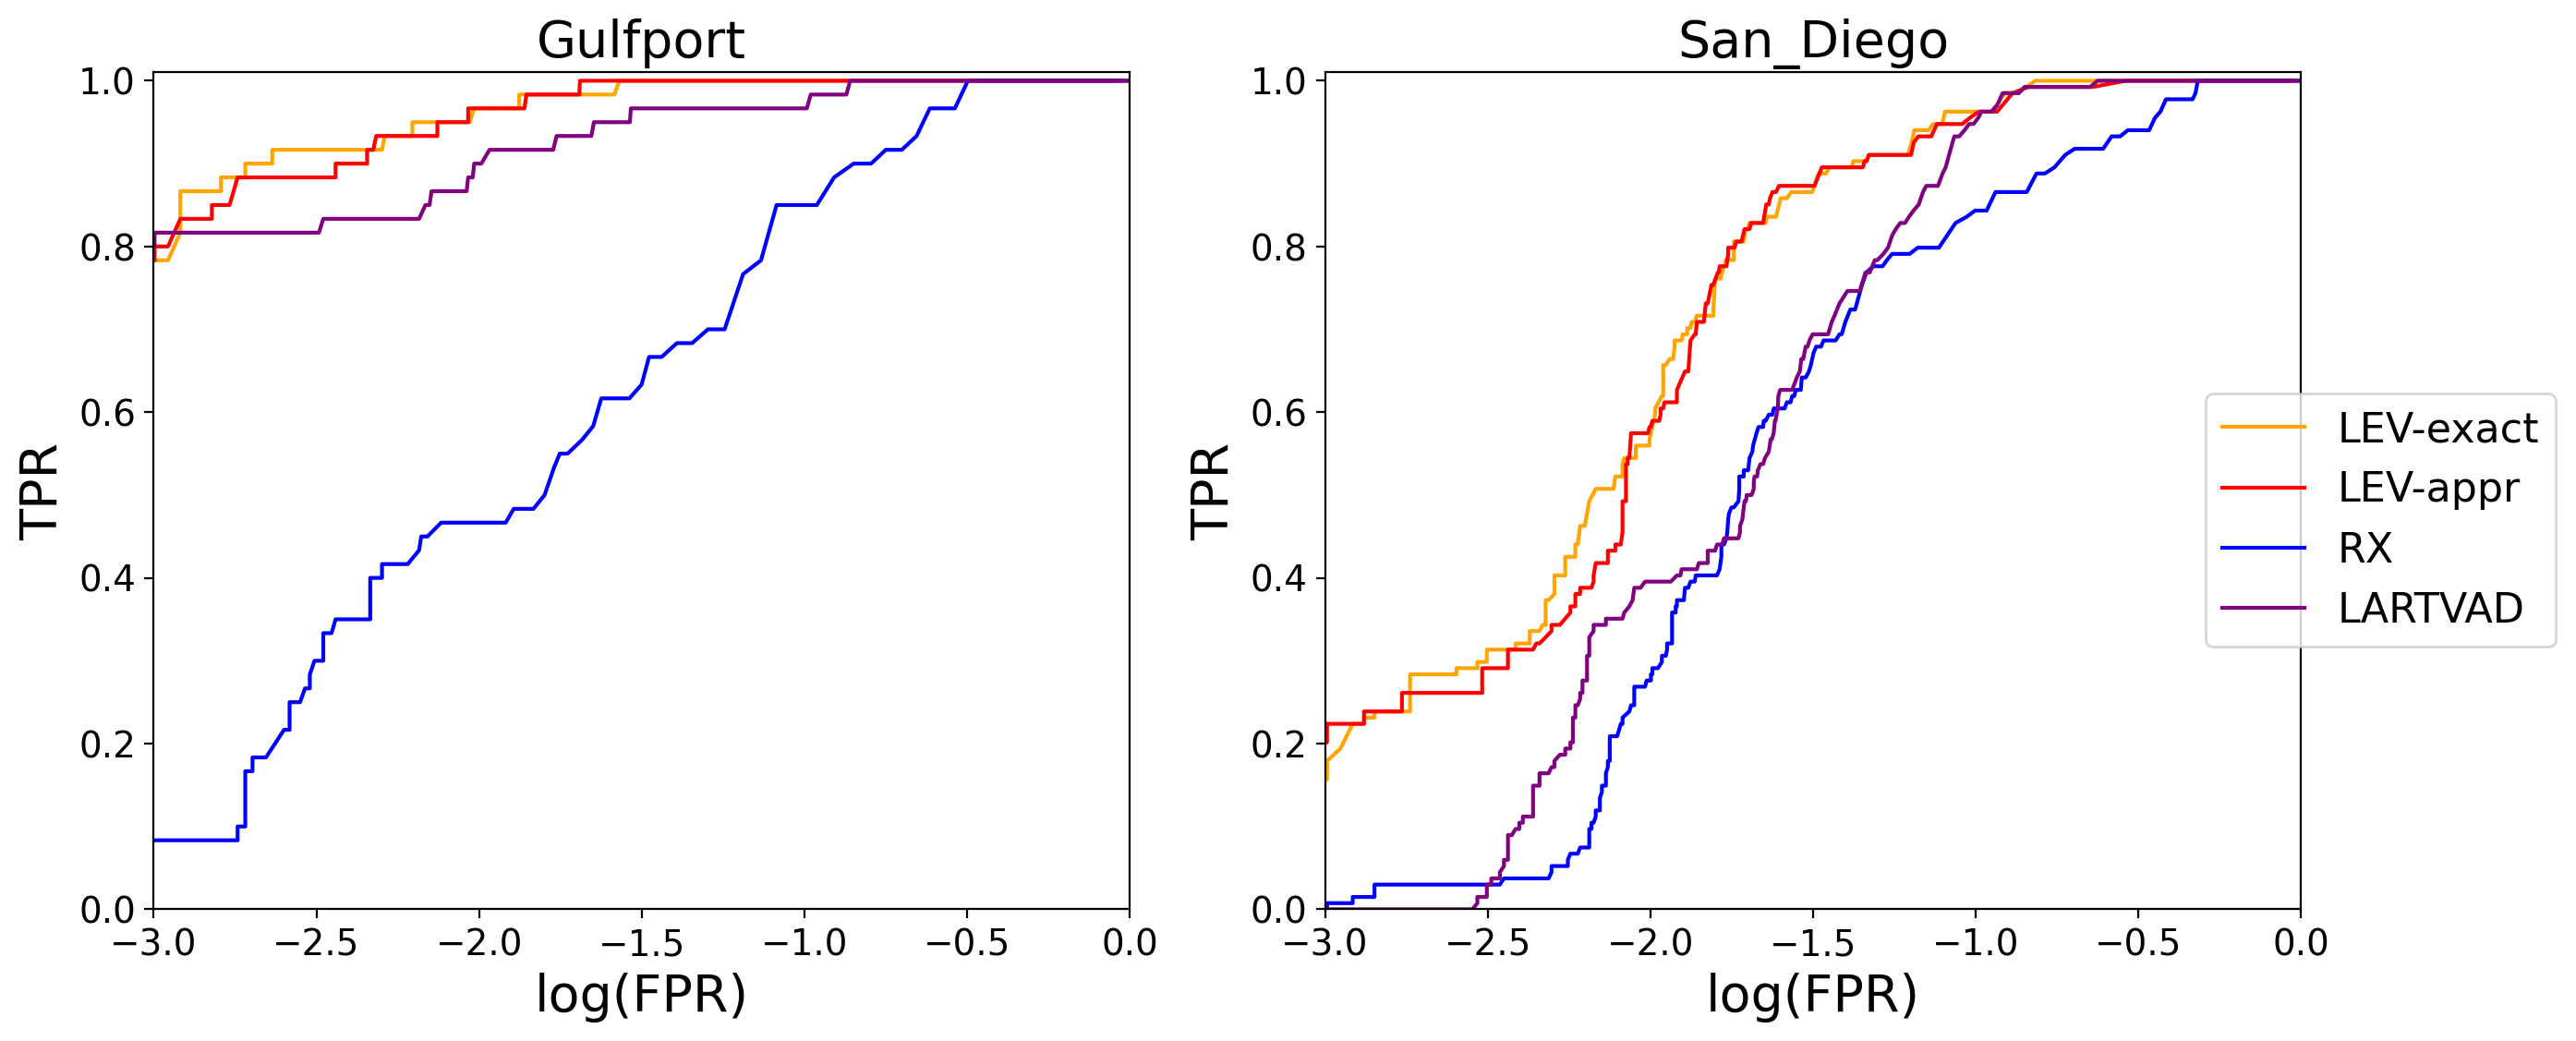

In [12]:
warnings.filterwarnings("ignore")
L = len(file_names)
approach_list = ['lev', 'lev_fast', 'rxval', 'LARTVAD']
color = ['orange', 'red', 'blue', 'purple', 'orange', 'green', 'DeepSkyBlue', 'black', 'pink', 'hotpink']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), dpi=200, sharex=False, sharey=False)
i = 1
tau_list = np.linspace(0,1,1001)
for file_name in file_names:
    j = 0
    plt.subplot(1,2,i)
    exec('GT = map_dict["' + file_name + '"]')
    for approach in approach_list:
        exec('anomaly_score = ' + approach + '_dict["' + file_name + '"]')
        ROC = ROC_curve(anomaly_score, GT, tau_list=tau_list)
        TPR_list = ROC['TPR_list']
        FPR_list = ROC['FPR_list']
        if(approach == 'lev'):
            approach_name = 'LEV-exact'
        if(approach == 'lev_fast'):
            approach_name = 'LEV-appr'
        if(approach == 'rxval'):
            approach_name = 'RX'
        if(approach == 'LARTVAD'):
            approach_name = 'LARTVAD'
        plt.plot(np.log10(FPR_list)[:-1],TPR_list[:-1], label = approach_name, color = color[j], )
        plt.xlim([-3,0])
        plt.ylim([0,1.01])
        j = j + 1
    if(file_name == 'Airport'):
        plt.title('Gulfport', fontsize = 20)
    else:
        plt.title(file_name, fontsize = 20)
    plt.xlabel('log(FPR)', fontsize = 20)
    plt.ylabel('TPR', fontsize = 20)
    plt.tick_params(axis='both', labelsize=14)
    i = i + 1
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', fontsize = 16)
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()

In [13]:
GT = map_dict['Airport']
ROC = ROC_curve(lev_min_dict['Airport'], GT, tau_list=tau_list)
TPR_list = ROC['TPR_list']
FPR_list = ROC['FPR_list']

In [14]:
def AUC(TPR_list, FPR_list):
    L = len(TPR_list)
    area = TPR_list[0] * (1-FPR_list[0])
    for i in range(L-1):
        area = area + TPR_list[i+1] * (FPR_list[i] - FPR_list[i+1])
    return area

In [15]:
lev_min_AUC_dict = {}
lev_fast_min_AUC_dict = {}
rxval_AUC_dict = {}
LARTVAD_AUC_dict = {}
approach_list = ['lev_min', 'lev_fast_min', 'rxval', 'LARTVAD']
for file_name in file_names:
    exec('GT = map_dict["' + file_name + '"]')
    for approach in approach_list:
        exec('anomaly_score = ' + approach + '_dict["' + file_name + '"]')
        ROC = ROC_curve(anomaly_score, GT, tau_list=tau_list)
        TPR_list = ROC['TPR_list']
        FPR_list = ROC['FPR_list']
        exec(approach + '_AUC_dict["' + file_name + '"] = AUC(TPR_list, FPR_list)')

In [32]:
print("{:<20}{}".format("AUC of RX:", str(rxval_AUC_dict)))
print("{:<20}{}".format("AUC of LARTVAD:", str(LARTVAD_AUC_dict)))
print("{:<20}{}".format("AUC of LEV-exact:", str(lev_min_AUC_dict)))
print("{:<20}{}".format("AUC of LEV-appr:", str(lev_fast_min_AUC_dict)))

AUC of RX:          {'Airport': 0.9497887323943663, 'San_Diego': 0.9390353119865905}
AUC of LARTVAD:     {'Airport': 0.9938698859825608, 'San_Diego': 0.9685887912959027}
AUC of LEV-exact:   {'Airport': 0.9983165660630444, 'San_Diego': 0.9832070642126889}
AUC of LEV-appr:    {'Airport': 0.998276324614353, 'San_Diego': 0.9814106035805161}
